In [1]:
import os
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier,SGDClassifier,RidgeClassifier
from sklearn.model_selection import cross_validate,KFold,cross_val_score
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.preprocessing as sklPp
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.metrics import matthews_corrcoef
#from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV


MARKDOWN 


In [2]:
def getData():
    path = os.path.join(os.getcwd(),"latestdata.csv")
    #data = pd.read_csv(path,dtype = {"ID":str,"age":int,"sex":str,"city":str,"province":str,"country":str,"latitude":float,"longitude":float,"geo_resolution":str,"date_onset_symptoms":str,"date_admission_hospital":str,"date_confirmation":str,"symptoms":str,"lives_in_Wuhan":str,"travel_history_dates":str,"travel_history_location":str,"reported_market_exposure":str,"additional_information":str,"chronic_disease_binary":str,"chronic_disease":str,"source":str,"sequence_available":str,"outcome":str,"date_death_or_discharge":str,"notes_for_discussion":str,"location":str,"admin3":str,"admin2":str,"admin1":str,"country_new":str,"admin_id":int,"data_moderator_initials":str,"travel_history_binary":str})
    data = pd.read_csv(path,low_memory = False)
    print(data.head(5))
    return data

In [3]:
uncleaned = getData()

            ID  age     sex            city   province    country   latitude  \
0      000-1-1  NaN    male        Shek Lei  Hong Kong      China  22.365019   
1     000-1-10   78    male      Vo Euganeo     Veneto      Italy  45.297748   
2    000-1-100   61  female             NaN        NaN  Singapore   1.353460   
3   000-1-1000  NaN     NaN  Zhengzhou City      Henan      China  34.629310   
4  000-1-10000  NaN     NaN  Pingxiang City    Jiangxi      China  27.513560   

    longitude geo_resolution date_onset_symptoms  ... date_death_or_discharge  \
0  114.133808          point                 NaN  ...                     NaN   
1   11.658382          point                 NaN  ...              22.02.2020   
2  103.815100         admin0                 NaN  ...              17.02.2020   
3  113.468000         admin2                 NaN  ...                     NaN   
4  113.902900         admin2                 NaN  ...                     NaN   

  notes_for_discussion     locat

In [4]:
def cleanData(data): 
    columns = list(data.columns)
    #List of wanted columns is the list of columns excluding wanted columns, using set difference.
    unwantedCols = list(set(columns) - set(["age","sex","country","chronic_disease_binary","chronic_disease","outcome"])) 
    #Drop all unwanted columns
    data.drop(unwantedCols,axis =1,inplace = True)
    #Remove empty ages,outcomes, sex and countries
    data = data[data['age'].notnull()]
    data = data[data['outcome'].notnull()]
    data = data[data['sex'].notnull()]
    data = data[data['country'].notnull()]
    #Format ages (clears out 0.4/2012/70-80)
    data['age'] = data['age'].apply(alterAge)  
    #Remove newly created NaNs
    data = data[data['age'].notnull()]
    #Remove all entries where a chronic disease is listed but not given
    data.drop(data[(data.chronic_disease_binary == True)&(data.chronic_disease == "NaN")].index,inplace = True)
    #Remove certain outcomes
    invalidOutcomes = ['https://www.mspbs.gov.py/covid-19.php','Migrated','Migrated_Other','not hospitalized','Symptoms only improved with cough. Currently hospitalized for follow-up.','treated in an intensive care unit (14.02.2020)','unstable']
    data = data[~data['outcome'].isin(invalidOutcomes)]
    invalidDisease = ['https://coronavirus.dc.gov/page/coronavirus-data','Iran; Kuala Lumpur, Federal Territory of Kuala Lumpur, Malaysia','"thought to have had other pre-existing conditions"','Unspecified underlying medical condition','https://cv.nmhealth.org/2020/03/25/updated-new-mexico-covid-19-cases-now-at-112/','Previous confirmed case contact']
    data = data[~data['chronic_disease'].isin(invalidDisease)]
    fileSystem = os.path.join(os.getcwd(),"cleaned.csv")
    data.to_csv(fileSystem, index = False, header=True)
    print(len(data.index))
    print(data.head(15))
    data.reset_index(drop=True, inplace=True)
    return data

In [5]:
def encodeCategorical(data):
    #Create a label encoder
    lE = sklPp.LabelEncoder()
    #Encode the country column, then print out a dict with the values/nums
    data['country'] = lE.fit_transform(data['country'])
    countryMapping = dict(zip(lE.classes_, lE.transform(lE.classes_)))
    print("Countries \n",countryMapping)
    #Same thing for sex
    data['sex'] = lE.fit_transform(data['sex'])
    sexMapping = dict(zip(lE.classes_, lE.transform(lE.classes_)))
    print("Sex \n",sexMapping)
    #Same thing for disease true/false 
    data['chronic_disease_binary'] = lE.fit_transform(data['chronic_disease_binary'])
    diseaseMapping = dict(zip(lE.classes_, lE.transform(lE.classes_)))
    print("Pre-Existing Conditions \n",diseaseMapping)
    #Print out the defined outcome mapping then apply it to all items in the column
    print('Outcomes \n',{0: "Alive",1:"Treatment",2:"Critical Condition",3:"Dead"})
    data['outcome'] = data['outcome'].apply(outcomeCategorical)  
    print("Outcome Values:\n",data['outcome'].value_counts())
    #Replace characters to standardise cells with multiple disease listings
    data['chronic_disease'] = data['chronic_disease'].str.replace(":",",")
    data['chronic_disease'] = data['chronic_disease'].str.replace(";",",")
    #Split into individual disease
    sub_df = data['chronic_disease'].str.split(',', expand=True)
    #Split into dummies
    dummies = pd.get_dummies(sub_df)
    _, dummies.columns = zip(*dummies.columns.str.split('_'))
    #Removes whitespace
    dummies.rename(columns=lambda x: x.strip(), inplace=True)
    #Rename this column as its the same disease
    dummies.rename(columns = {'hypertensive':'hypertension'},inplace = True)
    #Group and take 1 if 1 present or 0 else
    dummies.groupby(dummies.columns, axis=1).max()
    #Drop all columns that don't appear a large amount
    dummies = dummies[dummies.columns[dummies.sum()>2]]
    dummies = dummies.groupby(dummies.columns, axis=1).max()
    #Drop the existing column
    data = data.drop('chronic_disease',axis = 1)
    #Add the new columns
    data = data.join(dummies)
    #Write out the csv for debug
    fileSystem = os.path.join(os.getcwd(),"encoded.csv")
    data.to_csv(fileSystem, index = False, header=True)
    print(data.head(10))
    return data

In [6]:
def outcomeCategorical(item):
    deathWords = ['dead','death','deceased','died']
    criticalWords = ['hospitalized','critical condition','critical condition, intubated as of 14.02.2020','severe','severe illness','unstable']
    #criticalWords = []
    treatmentWords = ['receiving treatment','under treatment']
    aliveWords = ['discharge','discharged','discharged from hospital','released from quarantine','alive','not hospitalized','recovered','recovering at home','recovering at home 03.03.2020','stable','stable condition',]
    words = [aliveWords,treatmentWords,criticalWords,deathWords]
    ordinalNum = -1
    for wordList in words:
        ordinalNum += 1
        for word in wordList:
            if item.lower() == word:
                item = ordinalNum
                return item
    

In [7]:
def alterAge(item):
    allNums = item.isnumeric()
    if allNums == False:
        if '-' in item:
            ages = item.split('-')
            if len(ages) == 2 and ages[1] != '':
                ages = [int(i) for i in ages]
                item = sum(ages)//len(ages)
                return item
    else:
        item = int(item)
        if item>0 and item < 100:
            return item
        
    return None

In [8]:
cleaned = cleanData(uncleaned)
encoded = encodeCategorical(cleaned)
#print(encoded)

33519
       age     sex      country  chronic_disease_binary chronic_disease  \
1     78.0    male        Italy                   False             NaN   
2     61.0  female    Singapore                   False             NaN   
113   28.0    male    Singapore                   False             NaN   
224   56.0  female    Singapore                   False             NaN   
335   79.0  female    Singapore                   False             NaN   
446   26.0    male    Singapore                   False             NaN   
557   25.0    male    Singapore                   False             NaN   
668   40.0    male    Singapore                   False             NaN   
779   43.0    male    Singapore                   False             NaN   
890   29.0    male    Singapore                   False             NaN   
1001  71.0  female    Singapore                   False             NaN   
1113   1.0    male    Singapore                   False             NaN   
1224  35.0    male 

In [9]:
def splitData(data):
    x = data.iloc[:,[True,True,True,True,False,True,True,True,True,True,True]]
    y = data.iloc[:,4]
    print(y)
    
    xTrain,xTest,yTrain,yTest = train_test_split(x, y, test_size=0.33,shuffle=True)
    return xTrain,xTest,yTrain,yTest

In [10]:
def linearRegression(trainX,testX,trainY,testY):
    model = LogisticRegression( class_weight="balanced",max_iter = 1000).fit(trainX, trainY)
    trainPredictions= list(model.predict(trainX))
    testPredictions = list(model.predict(testX))
    trainScore = 0
    testScore = 0
    testResults=list(testY)
    
    for i in range(0,len(testResults)):
        if testResults[i]==testPredictions[i]:
            testScore += 1
        if testResults[i] == trainPredictions[i]:
            trainScore += 1
    
    
    print("Overfitting:",trainScore-testScore)
    print('Training Set Score:',trainScore/len(testY))
    print('Test Set Score:',testScore/len(testY))
    
    return model

In [11]:
def PAC(trainX,testX,trainY,testY):
    model = PassiveAggressiveClassifier(class_weight = "balanced",max_iter = 1000).fit(trainX,trainY)
    trainPredictions= list(model.predict(trainX))
    testPredictions = list(model.predict(testX))
    trainScore = 0
    testScore = 0
    testResults=list(testY)
    
    for i in range(0,len(testResults)):
        if testResults[i]==testPredictions[i]:
            testScore += 1
        if testResults[i] == trainPredictions[i]:
            trainScore += 1
    
    
    print("PAC Overfitting:",trainScore-testScore)
    print('Training Set Score:',trainScore/len(testY))
    print('Test Set Score:',testScore/len(testY))
    return model

In [12]:
def SGD(trainX,testX,trainY,testY):
    model = SGDClassifier(class_weight = "balanced",max_iter = 1000).fit(trainX,trainY)
    trainPredictions= list(model.predict(trainX))
    testPredictions = list(model.predict(testX))
    trainScore = 0
    testScore = 0
    testResults=list(testY)
    
    for i in range(0,len(testResults)):
        if testResults[i]==testPredictions[i]:
            testScore += 1
        if testResults[i] == trainPredictions[i]:
            trainScore += 1
    
    
    print("SGD Overfitting:",trainScore-testScore)
    print('Training Set Score:',trainScore/len(testY))
    print('Test Set Score:',testScore/len(testY))
    return model

In [13]:
def decisionTree(trainX,testX,trainY,testY):
    model = DecisionTreeClassifier(class_weight = "balanced").fit(trainX,trainY)
    tree.plot_tree(model)
    trainPredictions= list(model.predict(trainX))
    testPredictions = list(model.predict(testX))
    trainScore = 0
    testScore = 0
    testResults=list(testY)
    
    for i in range(0,len(testResults)):
        if testResults[i]==testPredictions[i]:
            testScore += 1
        if testResults[i] == trainPredictions[i]:
            trainScore += 1
    
    
    print("Decision Tree Overfitting:",trainScore-testScore)
    print('Training Set Score:',trainScore/len(testY))
    print('Test Set Score:',testScore/len(testY))
    return model

In [14]:
def crossValidate(modelName, model,data):
    k = 10
    x = data.iloc[:,[True,True,True,True,False,True,True,True,True,True,True]]
    y = data.iloc[:,4]
    kFold = KFold(n_splits = k, shuffle = True)
    accuracy = 0
    for trainIndex , testIndex in kFold.split(x):
        XTrain , XTest = x.iloc[trainIndex,:],x.iloc[testIndex,:]
        yTrain , yTest = y[trainIndex] , y[testIndex]
        model.fit(XTrain,yTrain)
        #if modelName == "Decision Tree":
           # tree.plot_tree(model)
           # plt.figure(figsize=(100,100))  # set plot size (denoted in inches)
           # tree.plot_tree(model, fontsize=20)
           # plt.savefig('tree_high_dpi', dpi=1000)
           # plt.show()
           # return
        pred_values = model.predict(XTest)
        accuracy += matthews_corrcoef(pred_values , yTest)
    accuracy = 1/k * accuracy
    print(modelName + " accuracy: ",accuracy)

In [15]:
def comparePreVsNo(model):
    testData = []
    for preDisease in range(0,2):
        diseaseData = []
        #For each country
        for country in range(0,41):
            #For each sex
            for sex in range(0,2):
                #For each age
                for age in range(1,100):
                    testCase = [age,sex,country,preDisease,0,0,0,0,0,0]
                    diseaseData.append(testCase)
        testData.append(diseaseData)
    noExisting = pd.DataFrame(testData[0],columns = ["age","sex","country","chronic_disease_binary","asthma","chronic bronchitis","chronic kidney disease","chronic obstructive pulmonary disease","diabetes","hypertension"])
    existing = pd.DataFrame(testData[1],columns = ["age","sex","country","chronic_disease_binary","asthma","chronic bronchitis","chronic kidney disease","chronic obstructive pulmonary disease","diabetes","hypertension"])
    
    noExistingPreds = list(model.predict(noExisting))
    existingPreds = list(model.predict(existing))
    
    print("Data Size: ",len(existing))
    print("No-Existing Diseases")
    printResults(noExistingPreds)
    print("Existing Diseases")
    printResults(existingPreds)
    
    print("An difference in deaths of: +", (existingPreds.count(3)-noExistingPreds.count(3))/len(existing) )
    return [noExistingPreds,existingPreds]

In [16]:
def compareDiseases(model):
    asthmaData = []
    cBData = []
    cKData = []
    copdData = []
    diabetesData = []
    hyptenData = []
    for country in range(0,41):
            #For each sex
            for sex in range(0,2):
                #For each age
                for age in range(1,100):
                    asthmaData.append([age,sex,country,1,1,0,0,0,0,0])
                    cBData.append([age,sex,country,1,0,1,0,0,0,0])
                    cKData.append([age,sex,country,1,0,0,1,0,0,0])
                    copdData.append([age,sex,country,1,0,0,0,1,0,0])
                    diabetesData.append([age,sex,country,1,0,0,0,0,1,0])
                    hyptenData.append([age,sex,country,1,0,0,0,0,0,1])
    testData=[asthmaData,cBData,cKData,copdData,diabetesData,hyptenData]
    print(len(asthmaData))
    predictions = []
    for disease in testData:
        diseasePred = list(model.predict(disease))
        predictions.append(diseasePred)
    return predictions

In [17]:
#lR = LogisticRegression( class_weight="balanced",max_iter = 5000)
#pac = PassiveAggressiveClassifier(class_weight = "balanced",max_iter = 5000)
decTree = DecisionTreeClassifier(class_weight = "balanced")
sgd = SGDClassifier(class_weight = "balanced",max_iter = 5000)
#qda = QuadraticDiscriminantAnalysis()
#gnb = GaussianNB()
mlp = MLPClassifier()
#crossValidate("Logistic Regression",lR,encoded)
#crossValidate("Passive Aggressive",pac,encoded)
#crossValidate("QDA",qda,encoded)
#crossValidate("gnb",gnb,encoded)
crossValidate("Decision Tree",decTree,encoded)
crossValidate("SGD",sgd,encoded)
crossValidate("mlp",mlp,encoded)
print("\n")

Decision Tree accuracy:  0.6801212661739696
SGD accuracy:  0.5385353764753894
mlp accuracy:  0.8496765488421755




In [18]:
def printResults(results):
    dataSize = len(results)
    print("Alive",results.count(0)/dataSize)
    print("In Treatment",results.count(1)/dataSize)
    print("Critical Condition",results.count(2)/dataSize)
    print("Dead",results.count(3)/dataSize,end = "\n\n")

In [19]:
def generateGraph1(results):
    dataSize = len(results[0])
    labels = ["Without Pre-Existing Conditions","With Pre-Existing Conditions"]
    aliveMeans = [(results[0].count(0)/dataSize)*100,(results[1].count(0)/dataSize)*100]
    treatmentMeans = [(results[0].count(1)/dataSize)*100,(results[1].count(1)/dataSize)*100]
    criticalMeans = [(results[0].count(2)/dataSize)*100,(results[1].count(2)/dataSize)*100]
    deadMeans = [(results[0].count(3)/dataSize)*100,(results[1].count(3)/dataSize)*100]

    x = np.arange(len(labels))  # the label locations
    width = 0.10  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_figheight(15)
    fig.set_figwidth(20)
    rects1 = ax.bar(x - 1.5*width, aliveMeans, width, label='Alive')
    rects2 = ax.bar(x - 0.5*width, treatmentMeans, width, label='Treatment')
    rects3 = ax.bar(x + 0.5*width, criticalMeans, width, label='Critical')
    rects4 = ax.bar(x + 1.5*width, deadMeans, width, label='Dead')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_title('Outcomes with/without pre-existing condition')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)
    ax.bar_label(rects4, padding=3)
    #fig.tight_layout()
    plt.subplots_adjust(wspace=25)
    plt.rcParams.update({'font.size': 20})
    plt.xticks(fontsize=20)
    plt.show()

In [20]:
def generateGraph2(noDisRes,results):
    dataSize = len(results[0])
    labels = ["Without \n Pre-Existing \n Conditions","Asthma","Chronic \n Bronchitis","Chronic \n Kidney \n Disease","Chronic \n Obstructive \n Pulmonary \n Disease","Diabetes","Hypertension"]
    aliveMeans = [(noDisRes.count(0)/dataSize)*100]
    treatmentMeans = [(noDisRes.count(1)/dataSize)*100]
    criticalMeans = [(noDisRes.count(2)/dataSize)*100]
    deadMeans = [(noDisRes.count(3)/dataSize)*100]
    print("Increase in dead:")
    for result in results:
        aliveMeans.append((result.count(0)/dataSize)*100)
        treatmentMeans.append((result.count(1)/dataSize)*100)
        criticalMeans.append((result.count(2)/dataSize)*100)
        deadMeans.append((result.count(3)/dataSize)*100)
        difference = round((((result.count(3)/dataSize)*100)-((noDisRes.count(3)/dataSize)*100)),2)
        print(difference)
   
    x = np.arange(len(labels))  # the label locations
    width = 0.20  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_figheight(15)
    fig.set_figwidth(20)
    rects1 = ax.bar(x - 1.5*width, aliveMeans, width, label='Alive')
    rects2 = ax.bar(x - 0.5*width, treatmentMeans, width, label='Treatment')
    rects3 = ax.bar(x + 0.5*width, criticalMeans, width, label='Critical')
    rects4 = ax.bar(x + 1.5*width, deadMeans, width, label='Dead')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_title('Outcome by pre-existing condition')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.subplots_adjust(wspace=25)
    plt.xticks(fontsize=20)
    plt.show()

Decision Tree
Data Size:  8118
No-Existing Diseases
Alive 0.6390736634639074
In Treatment 0.02833210150283321
Critical Condition 0.0646711012564671
Dead 0.26792313377679233

Existing Diseases
Alive 0.5375708302537571
In Treatment 0.0
Critical Condition 0.0646711012564671
Dead 0.3977580684897758

An difference in deaths of: + 0.1298349347129835


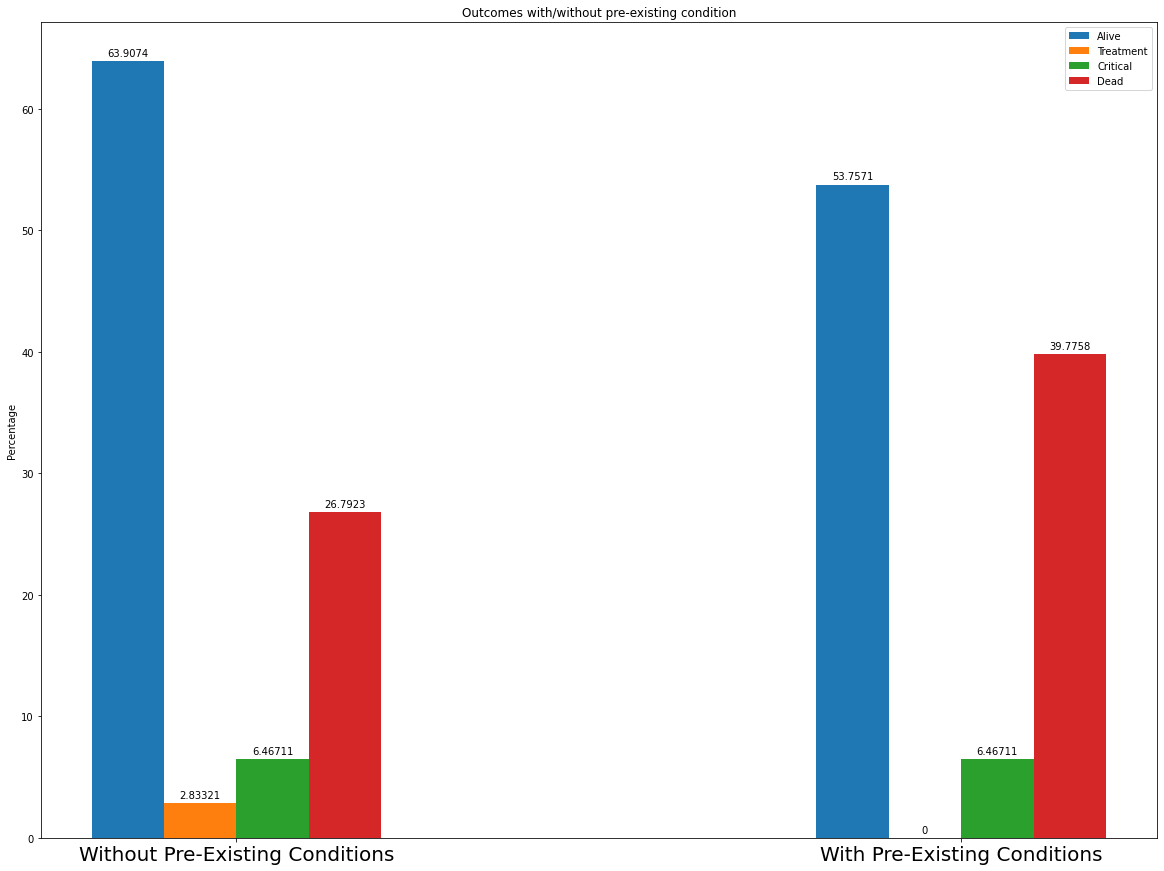

8118
Increase in dead:
11.58
12.98
13.57
12.98
36.59
16.11


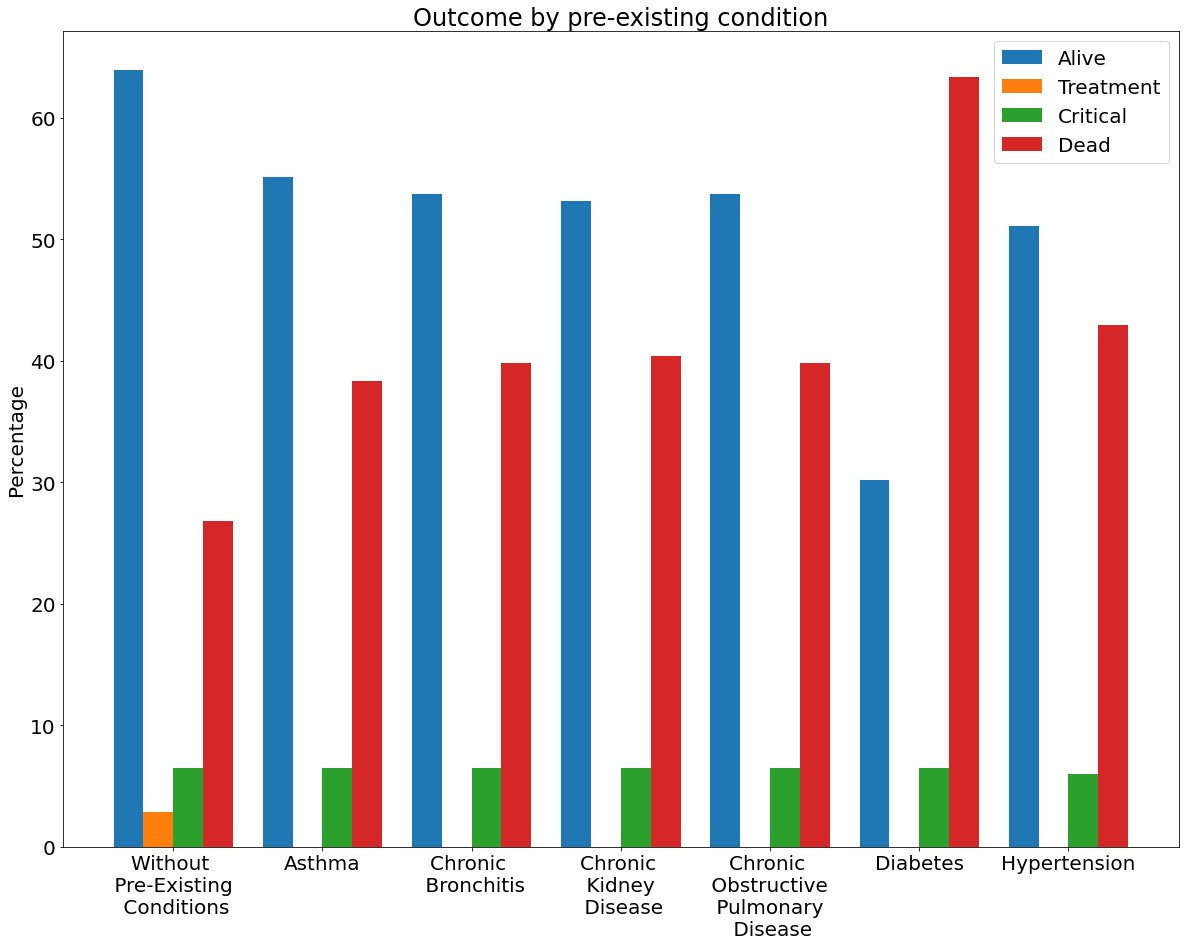

SGD
Data Size:  8118
No-Existing Diseases
Alive 0.1629711751662971
In Treatment 0.5134269524513427
Critical Condition 0.16839122936683912
Dead 0.15521064301552107

Existing Diseases
Alive 0.14794284306479427
In Treatment 0.5125646711012565
Critical Condition 0.16543483616654348
Dead 0.17405764966740578

An difference in deaths of: + 0.018847006651884702


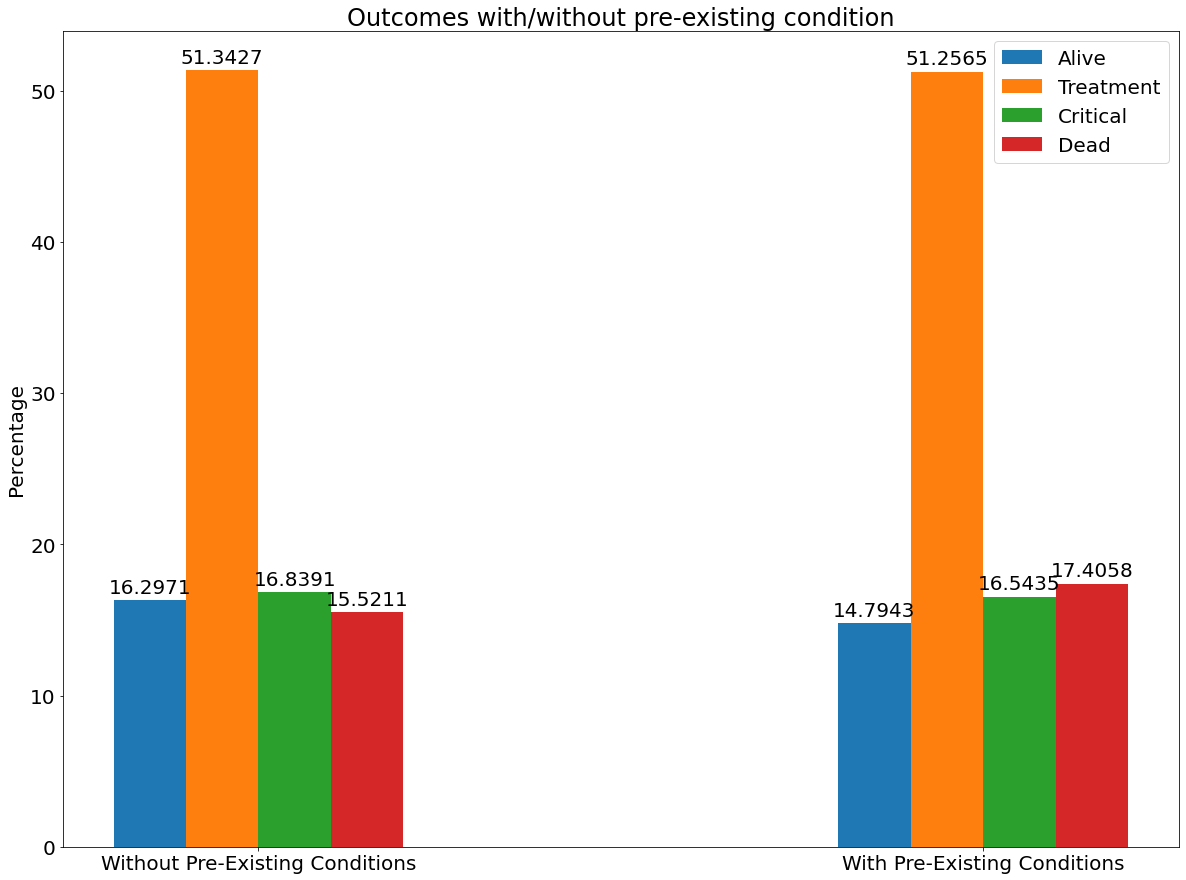

8118
Increase in dead:
1.97
2.13
2.03
2.02
3.1
3.08


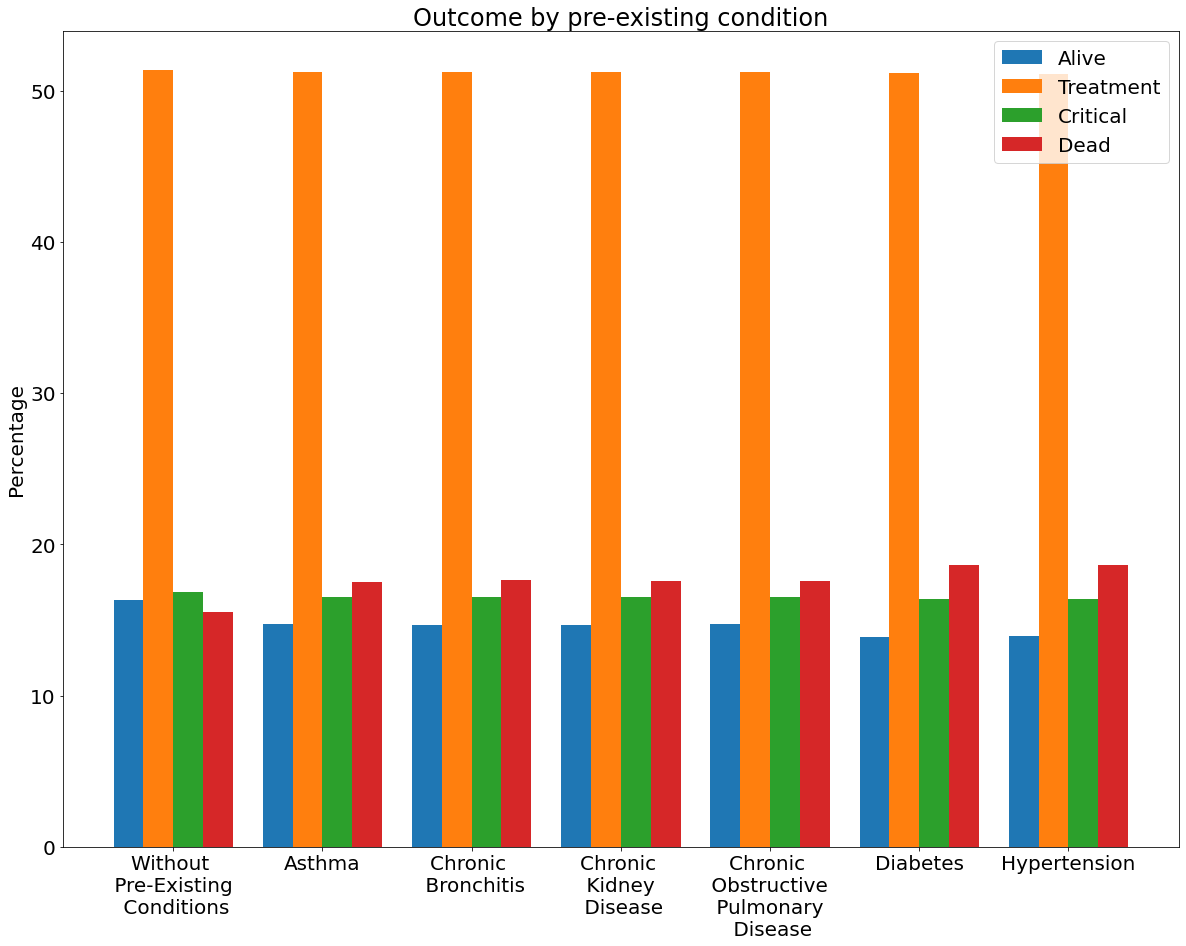

MLP
Data Size:  8118
No-Existing Diseases
Alive 0.6139443212613944
In Treatment 0.0
Critical Condition 0.22567134762256713
Dead 0.16038433111603842

Existing Diseases
Alive 0.7097807341709781
In Treatment 0.0
Critical Condition 0.002463661000246366
Dead 0.28775560482877555

An difference in deaths of: + 0.12737127371273713


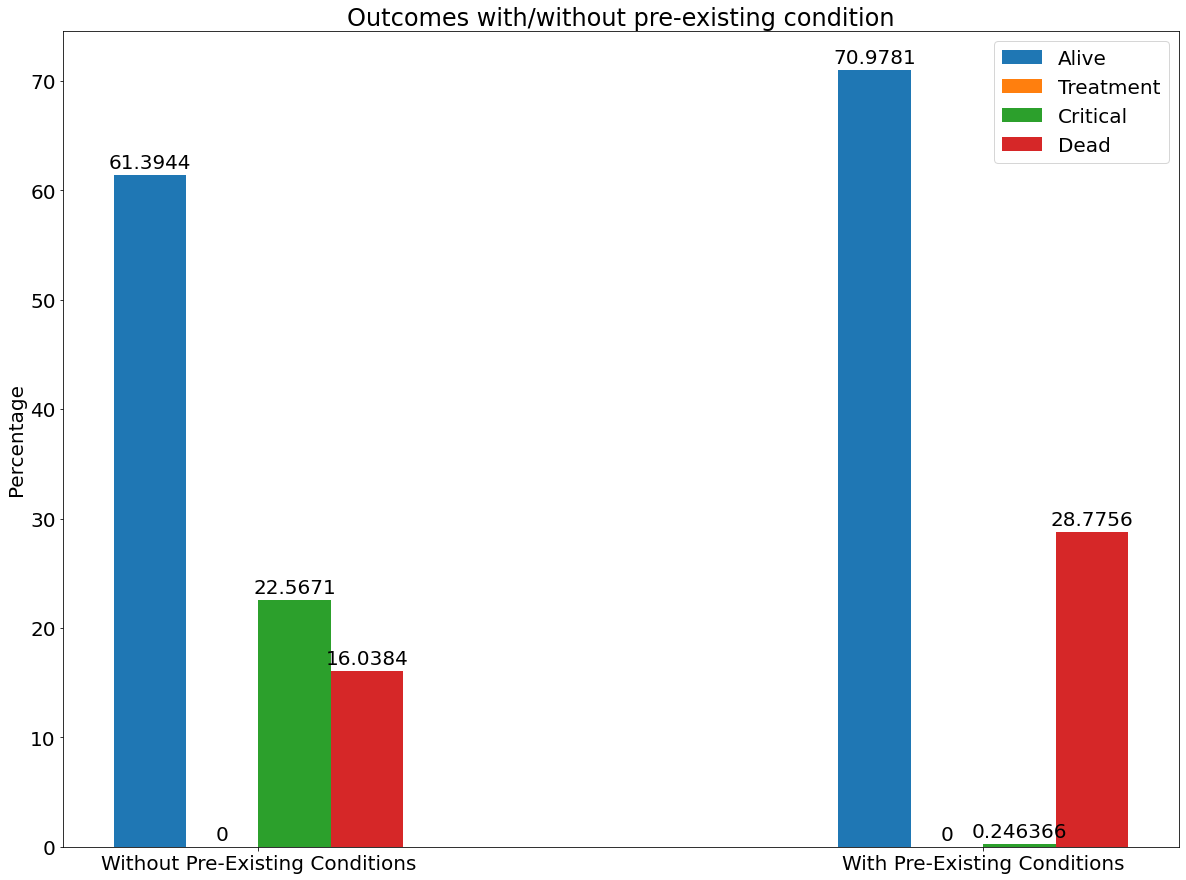

8118
Increase in dead:
21.29
29.58
53.73
40.22
73.06
22.8


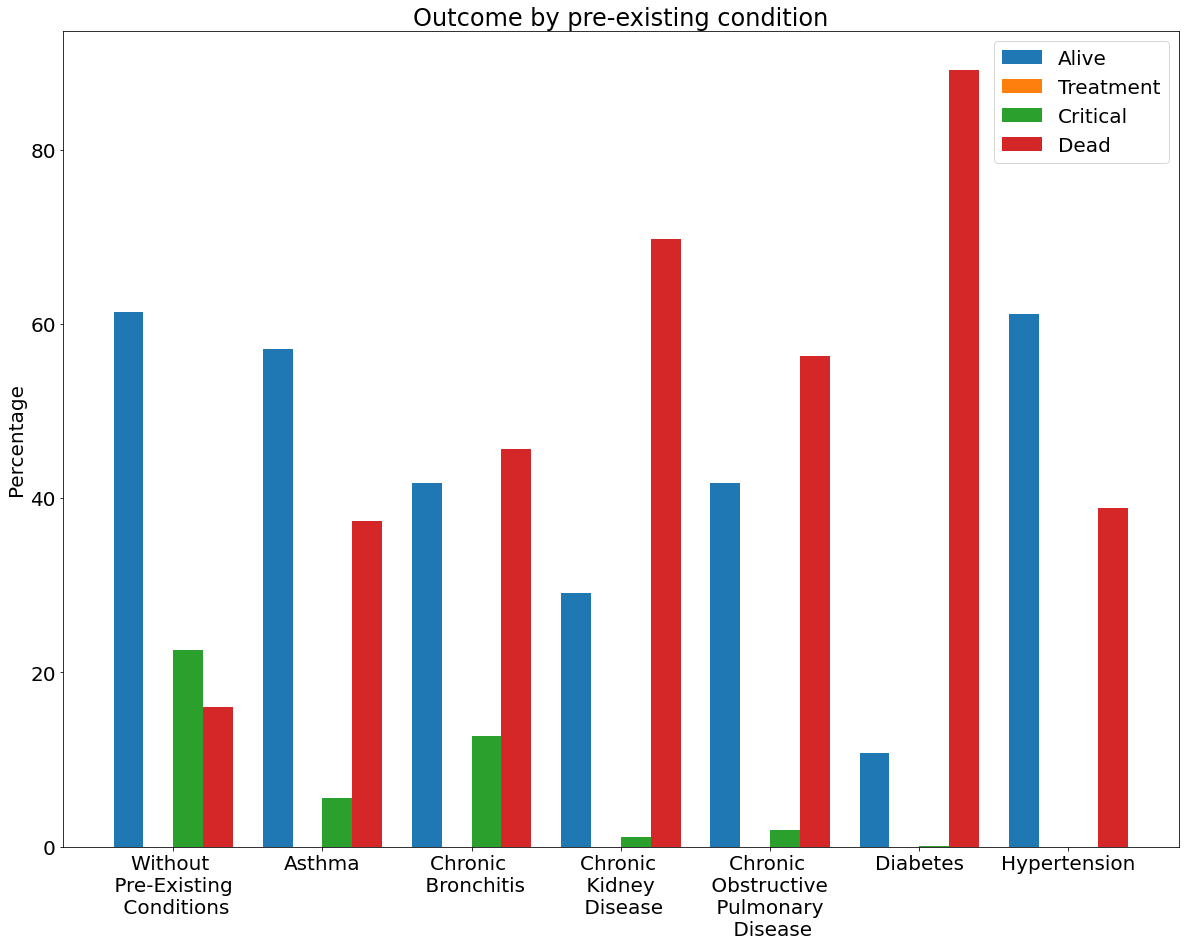

In [21]:
print("Decision Tree")
results = comparePreVsNo(decTree)
generateGraph1(results)
diseaseResults = compareDiseases(decTree)
generateGraph2(results[0],diseaseResults)
print("SGD")
results = comparePreVsNo(sgd)
generateGraph1(results)
diseaseResults = compareDiseases(sgd)
generateGraph2(results[0],diseaseResults)
print("MLP")
results = comparePreVsNo(mlp)
generateGraph1(results)
diseaseResults = compareDiseases(mlp)
generateGraph2(results[0],diseaseResults)